# Project: Traffic Signs Recognition
Group 9: Krishna Sai Tejaswini Kambhampati, Hongjin Wu

##**Import Libraries**

In [ ]:
#importing necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import pandas as pd
import imageio
import random
import re

from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.callbacks import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image 
from PIL.ImageDraw import Draw
from tensorflow.keras.utils import to_categorical


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Preparation 

## **Data Augmentation**

In [ ]:
# Define the Augmentations that will be applied to the dataset
# Using ImgAug library
 
image_augmentations = iaa.SomeOf( 2,
    [                                 
    iaa.Affine(scale=(0.5, 1.5)),  # Scale 
    iaa.Affine(rotate=(-60, 60)),  # Rotate
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),  # Shift the Image
    iaa.Multiply((0.5, 1.5)),  # Adjust brightness
    iaa.GaussianBlur(sigma=(1.0, 3.0)),  # Gaussian BlurBlur
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))  # Add Noise
])

In [ ]:
# Function to convert bounding box image into DataFrame 
def bounding_boxes_to_df(bounding_boxes_object):

    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()  # Convert Bounding Boxes Object to Array
     
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array,columns=['xmin', 'ymin', 'xmax', 'ymax'])  # Convert to DataFrame
     
    return df_bounding_boxes

In [ ]:
# Define a function to apply augmentation

def image_aug(df, images_path, aug_images_path, augmentor, no_aug = 3):
     
    # Defind head of DataFrame
    augmentations_df = pd.DataFrame(
        columns=['filename','width','height','class', 'xmin', 'ymin', 'xmax','ymax'])
     
    # Group data by filenames
    grouped_df = df.groupby('filename')
 
    # Create the directory for augmentated images
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)
 
    for i in range(no_aug):
       
      # Post Fix for different augmentation of one image
      image_postfix = str(i)
 
      # Apply augmentations to each image
      for filename in df['filename'].unique():
 
        augmented_path = os.path.join(aug_images_path, filename)+image_postfix+'.jpg'
 
        # Take one image at a time with its information
        single_image = grouped_df.get_group(filename)
        single_image = single_image.reset_index()
        single_image = single_image.drop(['index'], axis=1)   
         
        # Read the image
        image = imageio.imread(os.path.join(images_path, filename))
 
        # Get bounding box
        bounding_box_array = single_image.drop(['filename', 'width', 'height','class'], axis=1).values
 
        # Pass the bounding box to imgaug library
        bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, shape=image.shape)
 
        # Perform random 2 Augmentations
        image_aug, bounding_box_aug = augmentor(image=image,bounding_boxes=bounding_box)
         
        # Remove bounding box out of the image   
        bounding_box_aug = bounding_box_aug.remove_out_of_image()
 
        # Clip partially out of th image bounding box
        bounding_box_aug = bounding_box_aug.clip_out_of_image()
 
        # Remove images without boudning box
        if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
            pass
         
        else:   
          # Create the augmented image file
          imageio.imwrite(augmented_path, image_aug) 
 
          # Update image width and height after augmentation
          info_df = single_image.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
          for index, _ in info_df.iterrows():
              info_df.at[index, 'width'] = image_aug.shape[1]
              info_df.at[index, 'height'] = image_aug.shape[0]
 
          # Add the prefix to each image
          info_df['filename'] = info_df['filename'].apply(lambda x: x + image_postfix + '.jpg')
 
          # Create the augmented bounding boxes dataframe 
          bounding_box_df = bounding_boxes_to_df(bounding_box_aug)
 
          # Concatenate the filenames, height, width and bounding boxes 
          aug_df = pd.concat([info_df, bounding_box_df], axis=1)
 
          # Add all the information to augmentations df
          augmentations_df = pd.concat([augmentations_df, aug_df])            
       
    # Remove index
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(['index'], axis=1)
 
    return augmentations_df

In [ ]:
# Apply augmentation to Training dataset

training_label = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/training_data_preAug_with_neg.csv'
train_image_directory = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Training'

labels_df = pd.read_csv(training_label)

augmented_images_df = image_aug(labels_df, train_image_directory, '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Training_afAug', 
                                image_augmentations)
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/training_data_afAug_with_neg.csv', index=False)


# Create without 'no sign' label file
augmented_images_noNeg_df = augmented_images_df[(augmented_images_df['class']=='Stop Sign') | \
                                                (augmented_images_df['class']=='Speed Limit 35') ]

augmented_images_noNeg_df.to_csv('/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/training_data_afAug_no_neg.csv', index=False)


In [ ]:
# Check Dataset Size
print('Dataset Size before augmentations: ', len(labels_df))
print('Dataset Size after augmentations: ', len(augmented_images_df))

Dataset Size before augmentations:  285
Dataset Size after augmentations:  692


In [ ]:
# # Apply augmentation to Validation dataset

validation_label = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/validation_data_preAug_with_neg.csv'
validation_image_directory = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Validation'

labels_df = pd.read_csv(validation_label)

augmented_images_df = image_aug(labels_df, validation_image_directory, '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Validation_afAug', 
                                image_augmentations)
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('validation_data_afAug_with_neg.csv')

# Create without 'no sign' label file
augmented_images_noNeg_df = augmented_images_df[(augmented_images_df['class']=='Stop Sign') | \
                                                (augmented_images_df['class']=='Speed Limit 35') ]

augmented_images_noNeg_df.to_csv('/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/validation_data_afAug_no_neg.csv', index=False)


In [ ]:
# Check Dataset Size
print('Dataset Size before augmentations: ', len(labels_df))
print('Dataset Size after augmentations: ', len(augmented_images_df))

Dataset Size before augmentations:  72
Dataset Size after augmentations:  176


##**Initialize and load images and files**

In [ ]:
#initialize the parameters
width = 300 
height = 300
num_classes = 3
#classification labels
classes = ["Stop Sign","Speed Limit 35","No Label"]


#Use the no_neg tag files to load, for the first run ,to generate the base model that performs regression for Bounding box
TRAINING_CSV_FILE = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/training_data_afAug_no_neg.csv'
TRAINING_IMAGE_DIR = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Training_afAug'

#corresponding Validation dataset
VALIDATION_CSV_FILE = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/validation_data_afAug_no_neg.csv'
VALIDATION_IMAGE_DIR = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Validation_afAug'


training_image_records = pd.read_csv(TRAINING_CSV_FILE)
validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

#for every image in training directory, join its path to the corresponding coordinates
for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img) #converting them into arrays
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)# append images to list
    train_targets.append((xmin, ymin, xmax, ymax))#append coordinates to targets
    train_labels.append(classes.index(class_name))#append classes to labels

#one hot encoding of train_labels
train_labels = to_categorical(train_labels,3)

validation_images = []
validation_targets = []
validation_labels = []

#same steps on validation directory
for index, row in validation_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = keras.preprocessing.image.load_img(validation_image_fullpath, target_size=(height, width))
    validation_img_arr = keras.preprocessing.image.img_to_array(validation_img)
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    validation_images.append(validation_img_arr)
    validation_targets.append((xmin, ymin, xmax, ymax))
    validation_labels.append(classes.index(class_name))

#one hot encoding of validation_labels 
validation_labels = to_categorical(validation_labels,3)


In [ ]:
train_images[19]

array([[[ 76., 129., 161.],
        [ 84., 137., 169.],
        [ 99., 152., 184.],
        ...,
        [ 75., 129., 175.],
        [ 75., 129., 175.],
        [ 70., 124., 170.]],

       [[ 71., 124., 156.],
        [ 87., 140., 172.],
        [ 76., 129., 161.],
        ...,
        [ 78., 132., 178.],
        [ 80., 134., 180.],
        [ 77., 131., 177.]],

       [[ 78., 131., 163.],
        [ 78., 131., 163.],
        [ 83., 136., 168.],
        ...,
        [ 76., 130., 176.],
        [ 77., 131., 177.],
        [ 76., 130., 176.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  8.,   8.,   8.],
        ...,
        [ 70.,  73.,  62.],
        [ 67.,  69.,  58.],
        [ 69.,  71.,  58.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  8.,   8.,   8.],
        ...,
        [ 72.,  75.,  66.],
        [ 71.,  73.,  62.],
        [ 77.,  77.,  67.]],

       [[  3.,   3.,   3.],
        [  4.,   4.,   4.],
        [  7.,  

In [ ]:
train_labels[1]

array([1., 0., 0.], dtype=float32)

## **Bounding Box Visualization**

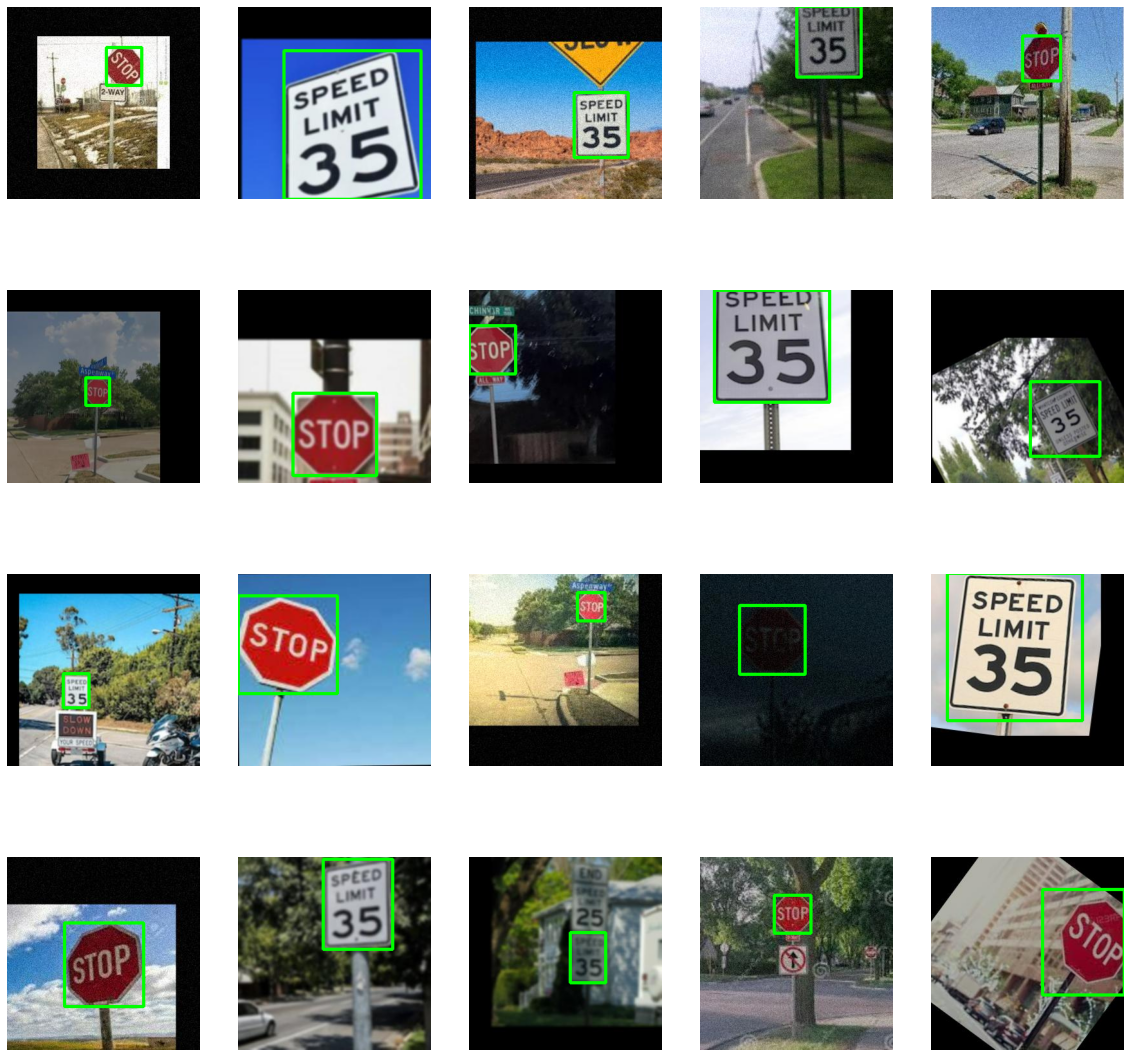

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));
 
# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(training_image_records)), 20)

for iteration, i in enumerate(random_range, 1):
 
    # Bounding box of each image
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = training_image_records.iloc[i]
 
    # The image to visualize
    image_path = os.path.join(train_image_path, filename)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
    # Draw bounding boxes on the image
    cv2.rectangle(img, (int(xmin),int(ymin)),
          (int(xmax),int(ymax)),(0,255,0),3);
     
    # Clip the values to 0-1 and draw the sample of images
    #img = np.clip(img, 0, 1)
    plt.subplot(4, 5, iteration);
    plt.imshow(np.real(img));
    plt.axis('off');

# 2. Model Creation

##**Building the model**

In [ ]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)
input_layer

<KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
#Base layers for Feature Extraction
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#Classification head layers from the output of the final base layer
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes,activation = 'softmax', name='cl_head')(classifier_branch)
 
#Localization head layers from the output of the final base layer
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [ ]:
#Define 2 outputs for the model
model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 300, 300, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                              

##**Baseline model Compilation**

In [ ]:
#Define the specific loss for each head using a dictionary
losses = {"cl_head":tf.keras.losses.CategoricalCrossentropy(), "bb_head":tf.keras.losses.MSE}

In [ ]:
#adam optimization
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [ ]:
training_epochs = 30

#convert the images to arrays
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)
validation_labels = np.array(validation_labels)


In [ ]:
#Define the targets for each head 
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}

validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [ ]:
print(type(trainTargets))

<class 'dict'>


##**Baseline model Fitting**

In [ ]:
history = model.fit(train_images, trainTargets,
                   validation_data=(validation_images, validationTargets),
                   batch_size=30,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/30
20/20 [==============================] - 12s 114ms/step - loss: 1.0293 - cl_head_loss: 0.9787 - bb_head_loss: 0.0506 - cl_head_accuracy: 0.6200 - bb_head_accuracy: 0.7565 - val_loss: 0.5235 - val_cl_head_loss: 0.4845 - val_bb_head_loss: 0.0390 - val_cl_head_accuracy: 0.8429 - val_bb_head_accuracy: 0.8214
Epoch 2/30
20/20 [==============================] - 1s 70ms/step - loss: 0.4933 - cl_head_loss: 0.4506 - bb_head_loss: 0.0427 - cl_head_accuracy: 0.7945 - bb_head_accuracy: 0.7737 - val_loss: 0.4358 - val_cl_head_loss: 0.4012 - val_bb_head_loss: 0.0345 - val_cl_head_accuracy: 0.8357 - val_bb_head_accuracy: 0.8500
Epoch 3/30
20/20 [==============================] - 1s 68ms/step - loss: 0.3231 - cl_head_loss: 0.2945 - bb_head_loss: 0.0287 - cl_head_accuracy: 0.8946 - bb_head_accuracy: 0.8273 - val_loss: 0.2984 - val_cl_head_loss: 0.2773 - val_bb_head_loss: 0.0210 - val_cl_head_accuracy: 0.8857 - val_bb_head_accuracy: 0.8214
Epoch 4/30
20/20 [==============================] - 2

##**Baseline model Performance**

In [ ]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



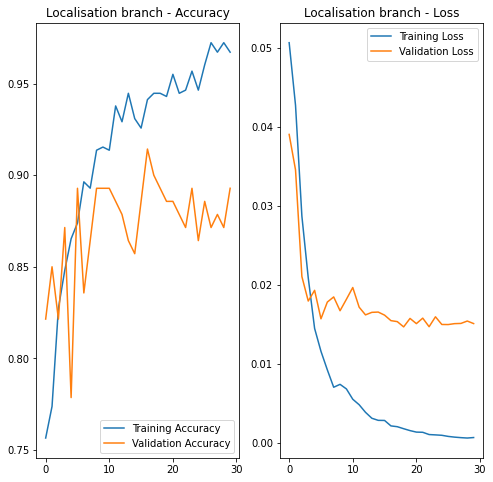

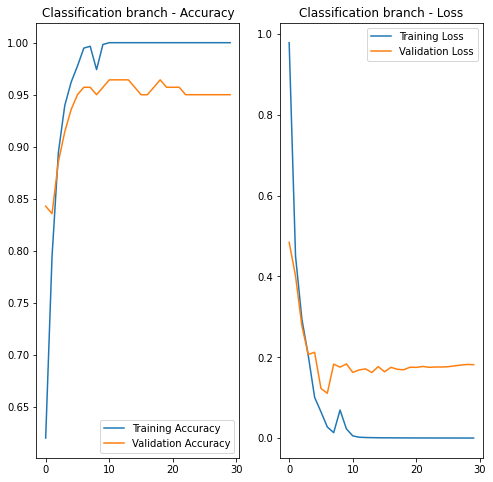

In [ ]:
epochs_range = range(training_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

In [ ]:
validation_img = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Test_data/AnyConv.com__13.jpg'

img = keras.preprocessing.image.load_img(validation_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = model.predict(img)


1/1 [==============================] - 0s 22ms/step


In [ ]:

print(predictions[1][0])

[0.2610657  0.13233352 0.48095337 0.44638523]


In [ ]:
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))

[78.31970751285553, 39.70005512237549, 144.2860096693039, 133.91557037830353]
tf.Tensor([0.57611686 0.21194157 0.21194157], shape=(3,), dtype=float32)
Predicted class: Stop Sign


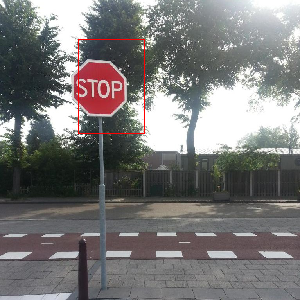

In [ ]:
testing = keras.preprocessing.image.load_img(validation_img, target_size=(height, width))
draw1 = Draw(testing)
draw1.rectangle(bbox, outline='red')
testing

##**Baseline Model save**

In [ ]:
model.save('/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Saved_Models/2classbaseLocator')

##**Use the Baseline model to Optimize the Classification accuracy**

In [ ]:
base_model = tf.keras.models.load_model('/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Saved_Models/2classbaseLocator')


In [ ]:
base_model.summary() #Initial summary before freezing

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 300, 300, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                              

In [ ]:
#freezing the respective layers
for layer in base_model.layers:
    if layer.name.startswith('bl_'):
        print(layer.name)
        layer.trainable = False
        
for layer in base_model.layers:
    if layer.name.startswith('bb_'):
        print(layer.name)
        layer.trainable = False


bl_1
bl_2
bl_3
bl_4
bl_5
bl_6
bl_7
bl_8
bb_1
bb_2
bb_3
bb_head


In [ ]:
base_model.summary()#model summary after freezing the parameters

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 300, 300, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                              

# 3. Model Training & Testing

##**Final Model Compilation**

In [ ]:
losses = {"cl_head":tf.keras.losses.CategoricalCrossentropy(), "bb_head":tf.keras.losses.MSE}


In [ ]:
width = 300
height = 300
num_classes = 3

classes = ["Stop Sign","Speed Limit 35","No Label"]

base_model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])


In [ ]:
#reload the file with zero coordinates for 
TRAINING_CSV_FILE = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/training_data_afAug_with_neg.csv'
VALIDATION_CSV_FILE = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/validation_data_afAug_with_neg.csv'
TRAINING_IMAGE_DIR = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Training_afAug'
VALIDATION_IMAGE_DIR = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Validation_afAug'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))
    training_epochs = 10

train_labels = to_categorical(train_labels,3)
    
val_images = []
val_targets = []
val_labels = []

for index, row in validation_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = keras.preprocessing.image.load_img(validation_image_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(validation_img)
    #img_arr = img_arr/255.0
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    val_images.append(test_img_arr)
    val_targets.append((xmin, ymin, xmax, ymax))
    val_labels.append(classes.index(class_name))


val_labels = to_categorical(val_labels,3)

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_targets = np.array(val_targets)
val_labels = np.array(val_labels)

trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
valTargets = {
    "cl_head": val_labels,
    "bb_head": val_targets
}


In [ ]:
train_images[5]

array([[[15., 26., 32.],
        [ 7., 18., 24.],
        [17., 28., 34.],
        ...,
        [20., 34., 43.],
        [11., 25., 34.],
        [ 5., 19., 28.]],

       [[27., 38., 44.],
        [18., 29., 35.],
        [20., 31., 37.],
        ...,
        [21., 35., 44.],
        [21., 35., 44.],
        [23., 37., 46.]],

       [[14., 25., 31.],
        [ 7., 18., 24.],
        [10., 21., 27.],
        ...,
        [11., 25., 34.],
        [16., 30., 39.],
        [24., 38., 47.]],

       ...,

       [[19., 23., 26.],
        [19., 23., 26.],
        [ 9., 13., 16.],
        ...,
        [ 8.,  8., 10.],
        [ 8.,  8., 10.],
        [ 2.,  2.,  4.]],

       [[14., 18., 21.],
        [15., 19., 22.],
        [ 9., 13., 16.],
        ...,
        [ 6.,  6.,  8.],
        [ 6.,  6.,  8.],
        [ 2.,  2.,  4.]],

       [[ 5.,  9., 12.],
        [ 8., 12., 15.],
        [ 8., 12., 15.],
        ...,
        [ 0.,  0.,  2.],
        [ 2.,  2.,  4.],
        [ 2.,  2.,  4.]]

In [ ]:
trainTargets

{'cl_head': array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32),
 'bb_head': array([[0.52, 0.03, 0.69, 0.2 ],
        [0.81, 0.31, 0.95, 0.43],
        [0.58, 0.31, 0.68, 0.4 ],
        ...,
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ]])}

##**Final model fitting**

In [ ]:
history = base_model.fit(train_images, trainTargets,
                   validation_data=(val_images, valTargets),
                   batch_size=30,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/10
24/24 [==============================] - 9s 75ms/step - loss: 1.0643 - cl_head_loss: 1.0125 - bb_head_loss: 0.0518 - cl_head_accuracy: 0.8439 - bb_head_accuracy: 0.8107 - val_loss: 0.8763 - val_cl_head_loss: 0.7947 - val_bb_head_loss: 0.0816 - val_cl_head_accuracy: 0.7784 - val_bb_head_accuracy: 0.7102
Epoch 2/10
24/24 [==============================] - 1s 49ms/step - loss: 0.3126 - cl_head_loss: 0.2608 - bb_head_loss: 0.0518 - cl_head_accuracy: 0.9191 - bb_head_accuracy: 0.8107 - val_loss: 0.7480 - val_cl_head_loss: 0.6665 - val_bb_head_loss: 0.0816 - val_cl_head_accuracy: 0.8125 - val_bb_head_accuracy: 0.7102
Epoch 3/10
24/24 [==============================] - 1s 45ms/step - loss: 0.2290 - cl_head_loss: 0.1772 - bb_head_loss: 0.0518 - cl_head_accuracy: 0.9523 - bb_head_accuracy: 0.8107 - val_loss: 0.7424 - val_cl_head_loss: 0.6608 - val_bb_head_loss: 0.0816 - val_cl_head_accuracy: 0.8636 - val_bb_head_accuracy: 0.7102
Epoch 4/10
24/24 [==============================] - 1s 

##**Final model Performance**

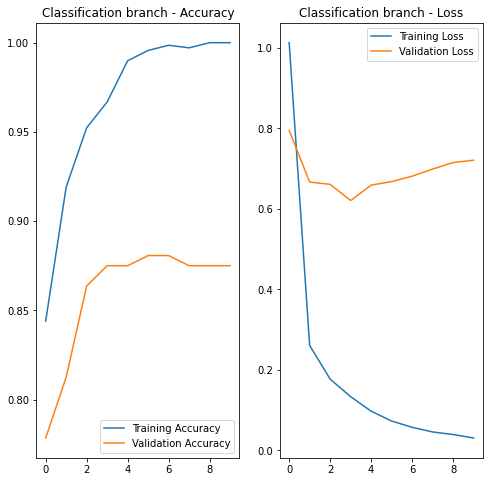

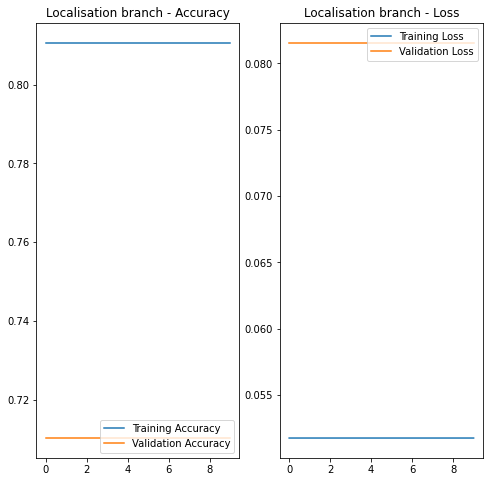

In [ ]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(training_epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

In [ ]:
base_model.save('/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Saved_Models/3classDetector')


##**Testing model on Test data**

1/1 [==============================] - 0s 224ms/step
[0.5236431  0.05561221 0.89280087 0.39027253]
[157.0929229259491, 16.683663055300713, 267.8402602672577, 117.08175837993622]
tf.Tensor([0.21280234 0.57199204 0.2152056 ], shape=(3,), dtype=float32)
Predicted class: Speed Limit 35


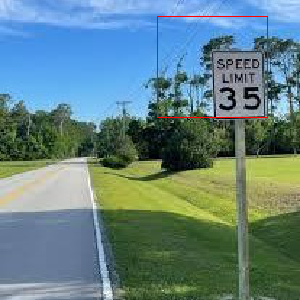

In [ ]:
test_img = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Test_data/AnyConv.com__9.jpg'

img = keras.preprocessing.image.load_img(test_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = base_model.predict(img)
print(predictions[1][0])
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))
testing = keras.preprocessing.image.load_img(test_img, target_size=(height, width))
draw1 = Draw(testing)
draw1.rectangle(bbox, outline='red')
testing

1/1 [==============================] - 0s 17ms/step
[0.24493985 0.08846276 0.7362177  0.54742676]
[73.4819546341896, 26.538828760385513, 220.86530327796936, 164.22802805900574]
tf.Tensor([0.57611686 0.21194157 0.21194157], shape=(3,), dtype=float32)
Predicted class: Stop Sign


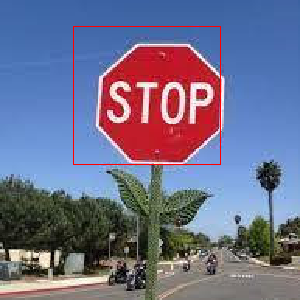

In [ ]:
test_img = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Test_data/AnyConv.com__4.jpg'

img = keras.preprocessing.image.load_img(test_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = base_model.predict(img)
print(predictions[1][0])
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))
testing = keras.preprocessing.image.load_img(test_img, target_size=(height, width))
draw1 = Draw(testing)
draw1.rectangle(bbox, outline='red')
testing

1/1 [==============================] - 0s 18ms/step
[0.51158345 0.3673727  0.6047626  0.37338728]
[153.47503423690796, 110.21180748939514, 181.42878413200378, 112.01618313789368]
tf.Tensor([0.21989009 0.24460651 0.5355034 ], shape=(3,), dtype=float32)
Predicted class: No Label


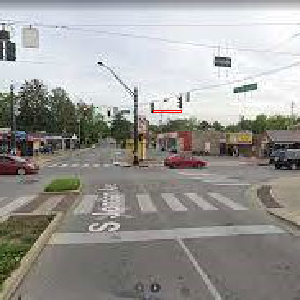

In [ ]:
test_img = '/content/drive/Shareddrives/MSIS2636_DeepLearning/Project/Final_Dataset/Images1/Test_data/AnyConv.com__12.jpg'

img = keras.preprocessing.image.load_img(test_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = base_model.predict(img)
print(predictions[1][0])
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))
testing = keras.preprocessing.image.load_img(test_img, target_size=(height, width))
draw1 = Draw(testing)
draw1.rectangle(bbox, outline='red')
testing

# 4. Alternative Attempt

## **Transfer Learning Model Attempt**

### Initialize and load images and files

In [ ]:
width = 300
height = 300
num_classes = 3
classes = ["Stop Sign", "Speed Limit 35","No Label"]

In [ ]:

train_images = []
train_targets = []
train_labels = []


# with class label converted to one-hot vector

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    img = cv2.imread(train_image_fullpath)
    train_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_img = train_img.astype("float") / 255.0
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img)
    train_targets.append([xmin, ymin, xmax, ymax])
    train_labels.append(classes.index(class_name))

train_labels = to_categorical(train_labels)


validation_images = []
validation_targets = []
validation_labels = []

for index, row in validation_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    validation_image_fullpath = os.path.join(validation_image_path, filename)
    img = cv2.imread(validation_image_fullpath)
    validation_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    validation_img = validation_img.astype("float") / 255.0
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    validation_images.append(validation_img)
    validation_targets.append([xmin, ymin, xmax, ymax])
    validation_labels.append(classes.index(class_name))

validation_labels = to_categorical(validation_labels)


### Build Transfer Model

In [ ]:
# Load the NasNetMobile Model, and exclude the top for transfer learning

N_mobile = tf.keras.applications.NASNetMobile(input_tensor = keras.Input(
    shape=(height, width, 3)), 
    include_top=False, 
    weights='imagenet'
    )

19993432/19993432 [==============================] - 1s 0us/step


In [ ]:
# Freeze the whole model
N_mobile.trainable = False

# Start by taking the output feature maps from NASNETMobile
base_model_output = N_mobile.output

# Flattern the output 
flattened_output = layers.GlobalAveragePooling2D()(base_model_output)

# Create Classification Head, final layer contains 
# Ouput units = no. classes
class_prediction = layers.Dense(256, activation="relu")(flattened_output)
class_prediction = layers.Dense(128, activation="relu")(class_prediction )
class_prediction = layers.Dropout(0.2)(class_prediction)
class_prediction = layers.Dense(64, activation="relu")(class_prediction)
class_prediction = layers.Dropout(0.2)(class_prediction )
class_prediction = layers.Dense(32, activation="relu")(class_prediction)
class_prediction = layers.Dense(len(classes), activation='softmax',name="class_output")(class_prediction)
 
# Create Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
box_output = layers.Dense(256, activation="relu")(flattened_output)
box_output = layers.Dense(128, activation="relu")(box_output)
box_output = layers.Dropout(0.2)(box_output )
 
box_output = layers.Dense(64, activation="relu")(box_output)
box_output = layers.Dropout(0.2)(box_output )
 
box_output = layers.Dense(32, activation="relu")(box_output)
box_predictions = layers.Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)
 

In [ ]:
model = keras.Model(inputs=N_mobile.input, outputs= [box_predictions, class_prediction])

### Compile Model

In [ ]:
# Define loss functions
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }

In [ ]:
# Set the Metrics
metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }

In [ ]:
loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }

In [ ]:
# Define early stop
stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True)

In [ ]:
# Change the learning rate according to number of epochs
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 40, min_lr = 1e-7, verbose = 1)

In [ ]:
# Initialize Optimizer
opt = keras.optimizers.SGD(lr = 1e-3, momentum = 0.9)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Compile model

In [ ]:
# Compile the model 
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)

### Train model

In [ ]:
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)
validation_labels = np.array(validation_labels)

In [ ]:
batchSize = 32
no_epochs = 100

In [ ]:
history = model.fit(x = train_images, 
                    y= {
                        "box_output": train_targets, 
                        "class_output": train_labels
                        }, 
                    validation_data=(
                        validation_images, 
                        {
                          "box_output": validation_targets, 
                          "class_output": validation_labels
                          }), 
                   batch_size = batchSize, 
                   epochs = no_epochs,
                   callbacks=[reduce_lr, stop],
                   shuffle=True
                   )

Epoch 1/100
22/22 [==============================] - 166s 7s/step - loss: 1.1842 - box_output_loss: 0.1152 - class_output_loss: 1.0689 - box_output_mse: 0.1152 - class_output_accuracy: 0.3844 - val_loss: 1.1502 - val_box_output_loss: 0.1169 - val_class_output_loss: 1.0333 - val_box_output_mse: 0.1169 - val_class_output_accuracy: 0.4432 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 133s 6s/step - loss: 1.1041 - box_output_loss: 0.1054 - class_output_loss: 0.9987 - box_output_mse: 0.1054 - class_output_accuracy: 0.4436 - val_loss: 1.1001 - val_box_output_loss: 0.1072 - val_class_output_loss: 0.9928 - val_box_output_mse: 0.1072 - val_class_output_accuracy: 0.4830 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 135s 6s/step - loss: 1.0447 - box_output_loss: 0.0995 - class_output_loss: 0.9452 - box_output_mse: 0.0995 - class_output_accuracy: 0.5477 - val_loss: 1.0599 - val_box_output_loss: 0.1001 - val_class_output_loss: 0.9598 - val_box_output_mse: 0.1

In [ ]:
def plot(var1, var2, plot_name):
  # Get the loss metrics from the trained model
  c1 = history.history[var1]
  c2 = history.history[var2]
 
  epochs = range(len(c1))
   
  # Plot the metrics
  plt.plot(epochs, c1, 'b', label=var1)
  plt.plot(epochs, c2, 'r', label=var2)
  plt.title(str(plot_name))
  plt.legend()

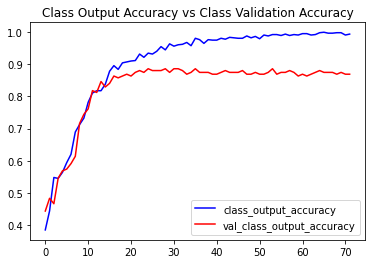

In [ ]:
# plot the accuracy & loss for classification 

plot( 'class_output_accuracy', 'val_class_output_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')

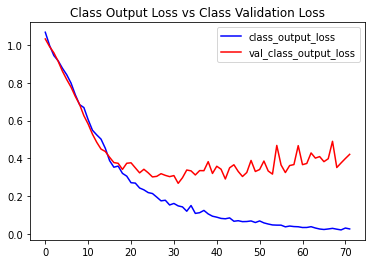

In [ ]:
plot( 'class_output_loss', 'val_class_output_loss', 'Class Output Loss vs Class Validation Loss')

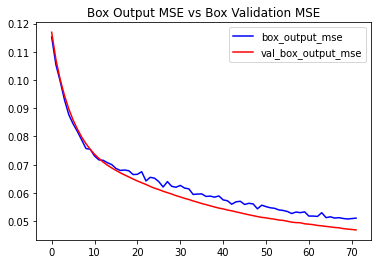

In [ ]:
# plot the accuracy and loss for localization 

plot( 'box_output_mse', 'val_box_output_mse', 'Box Output MSE vs Box Validation MSE')

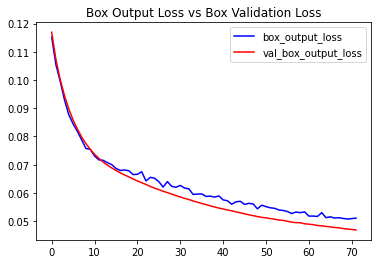

In [ ]:
plot('box_output_loss', 'val_box_output_loss', 'Box Output Loss vs Box Validation Loss')